# Train a custom CNN network to classify normal cervix images

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
from datetime import datetime
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Project
import sys
sys.path.append(os.path.join(os.path.abspath(os.path.dirname('.')), '..', 'common'))

In [4]:
import matplotlib.pylab as plt
%matplotlib inline

def plt_st(n, m):
    plt.figure(figsize=(n, m))

In [57]:
from custom_cnn_keras122 import get_cnn_4, get_alexnet

In [60]:
optimizer = 'adam'
lr_base = 0.001
cnn = get_cnn_4(optimizer=optimizer, lr=lr_base)

In [61]:
cnn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_17 (InputLayer)            (None, 3, 299, 299)   0                                            
____________________________________________________________________________________________________
convolution2d_89 (Convolution2D) (None, 32, 297, 297)  896         input_17[0][0]                   
____________________________________________________________________________________________________
batchnormalization_39 (BatchNorm (None, 32, 297, 297)  128         convolution2d_89[0][0]           
____________________________________________________________________________________________________
activation_49 (Activation)       (None, 32, 297, 297)  0           batchnormalization_39[0][0]      
___________________________________________________________________________________________

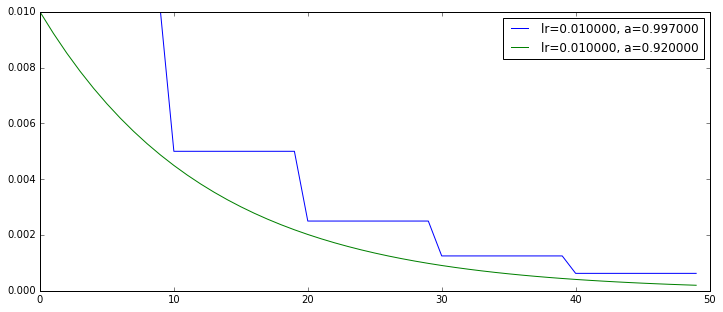

In [8]:
from training_utils import exp_decay, step_decay

lr_1 = 1.0 * lr_base; a_1 = 0.997
lr_2 = 1.0 * lr_base; a_2 = 0.92

epochs = np.arange(0, 50)
lrs_1 = step_decay(epochs, lr=lr_1, period=10)
lrs_2 = exp_decay(epochs, lr=lr_2, a=a_2)
plt_st(12, 5)
plt.plot(epochs, lrs_1, label="lr=%f, a=%f" % (lr_1, a_1))
plt.plot(epochs, lrs_2, label="lr=%f, a=%f" % (lr_2, a_2))
plt.legend()

In [62]:
seed = 54321
np.random.seed(seed)
save_prefix='cnn_4_cervix_normal_opt=%s_seed=%i' % (optimizer, seed)

In [10]:
from data_utils import GENERATED_DATA
print("\n {} - Get train/val lists ...".format(datetime.now()))

trainval_normal_id_type_list = np.load(os.path.join(GENERATED_DATA, 'normal_id_type_list.npz'))['normal_id_type_list']

# val_split=0.15
# ll = int(len(trainval_normal_id_type_list) * (1.0 - val_split))
# np.random.seed(seed)
# np.random.shuffle(trainval_normal_id_type_list)

# train_id_type_list = trainval_normal_id_type_list[:ll]
# val_id_type_list = trainval_normal_id_type_list[ll:]

# print(len(train_id_type_list), len(val_id_type_list))


 2017-05-03 20:39:35.263574 - Get train/val lists ...


In [11]:
def generate_trainval(id_type_list, seed, val_split=0.15):
    types = (('Type_1', 'AType_1'), ('Type_2', 'AType_2'), ('Type_3', 'AType_3'))
    out = [None, None, None]
    np.random.seed(seed)  
    for i, ts in enumerate(types):
        o = id_type_list[(id_type_list[:, 1] == ts[0]) | (id_type_list[:, 1] == ts[1])]
        out[i] = o

    ll = min([len(o) for o in out])
    out = np.array([o[:ll] for o in out])
    print out.shape
    out = out.reshape((3 * ll, 2))  
    np.random.shuffle(out)
    ll = int(len(out) * (1.0 - val_split))
    train_id_type_list = out[:ll]
    val_id_type_list = out[ll:]
    return train_id_type_list, val_id_type_list
    
train_id_type_list, val_id_type_list = generate_trainval(trainval_normal_id_type_list, seed)
print(len(train_id_type_list), len(val_id_type_list))

(3, 1079, 2)
(2751, 486)


In [12]:
def compute_type_distribution(id_type_list):
    types = (('Type_1', 'AType_1'), ('Type_2', 'AType_2'), ('Type_3', 'AType_3'))
    ll = len(id_type_list)
    out = [0.0, 0.0, 0.0]
    for i, ts in enumerate(types):
        for t in ts:
            out[i] += (id_type_list[:, 1] == t).sum()        
        out[i] *= 1.0 / ll
    return out

print compute_type_distribution(trainval_normal_id_type_list)
print compute_type_distribution(train_id_type_list)
print compute_type_distribution(val_id_type_list)

[0.21679726743017882, 0.5015069318866787, 0.2816958006831425]
[0.3326063249727372, 0.3307888040712468, 0.336604870956016]
[0.3374485596707819, 0.3477366255144033, 0.3148148148148148]


In [80]:
from glob import glob
from training_utils import find_best_weights_file

# weights_files = glob("weights/%s*.h5" % save_prefix)
# best_weights_filename, best_val_loss = find_best_weights_file(weights_files)
# print("Best val loss weights: ", best_weights_filename)
best_weights_filename = "weights/cnn_4_cervix_normal_opt=adam_seed=54321_23_val_loss=0.9313_val_acc=0.5779_val_precision=0.6964_val_recall=0.2930.h5"
if len(best_weights_filename) > 0:
    # load weights to the model
    print("Load found weights: ", best_weights_filename)
    cnn.load_weights(best_weights_filename)

('Load found weights: ', 'weights/cnn_4_cervix_normal_opt=adam_seed=54321_23_val_loss=0.9313_val_acc=0.5779_val_precision=0.6964_val_recall=0.2930.h5')


In [23]:
from xy_providers import DataCache
# cache = DataCache(0)

In [79]:
if True:
    from training_utils import classification_train as train
      
    nb_epochs = 50
    batch_size = 8
    
    lrate_decay_f = lambda epoch: step_decay(epoch, lr=lr_base * 0.00001, base=1.1, period=1) 

    print("\n {} - Start training ...".format(datetime.now()))
    h = train(cnn, 
              train_id_type_list, 
              val_id_type_list, 
              option='cervix',
              normalization='',
              nb_epochs=nb_epochs,
              image_size=(299, 299),
              samples_per_epoch=1.0 * len(train_id_type_list),
              nb_val_samples=len(val_id_type_list),
              lrate_decay_f=lrate_decay_f,
              batch_size=batch_size,
              xy_provider_cache=cache,
              #class_weight=class_weight,
              seed=seed,
              save_prefix=save_prefix)


 2017-05-04 00:19:21.878145 - Start training ...

-- Training parameters: 8, 50, 2752, 488

-- Fit stats of train dataset
Load existing file: /Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/input/generated/cnn_4_cervix_normal_opt=adam_seed=54321_stats.npz
No need to recompute statistics

-- Fit model
Epoch 1/50
2752/2752 [==============================] - 109s - loss: 0.9972 - acc: 0.5167 - recall: 0.2398 - precision: 0.5822 - val_loss: 0.9511 - val_acc: 0.5697 - val_recall: 0.2520 - val_precision: 0.6068
Epoch 2/50
 336/2752 [==>...........................] - ETA: 91s - loss: 1.0008 - acc: 0.5030 - recall: 0.2202 - precision: 0.6333

In [81]:
from training_utils import classification_validate as validate
from test_utils import classification_predict as predict

batch_size = 4

In [83]:
print("\n {} - Start validation ...".format(datetime.now()))
validate(cnn, 
         val_id_type_list,
         option='cervix',
         normalization='',
         image_size=(299, 299),
         save_prefix=save_prefix, 
         batch_size=batch_size, 
         xy_provider_cache=cache)


 2017-05-04 00:22:05.552055 - Start validation ...
Load existing file: /Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/input/generated/cnn_4_cervix_normal_opt=adam_seed=54321_stats.npz
('--', 4, 'batch loss : ', 0.80614877, ' | info:', array([('3889', 'AType_3'), ('1136', 'AType_2'), ('5459', 'AType_3'),
       ('1601', 'AType_1')], dtype=object))
('--', 8, 'batch loss : ', 1.670243, ' | info:', array([('1243', 'AType_1'), ('1901', 'AType_3'), ('2202', 'AType_3'),
       ('6345', 'AType_3')], dtype=object))
('--', 12, 'batch loss : ', 1.0114287, ' | info:', array([('4237', 'AType_3'), ('2849', 'AType_1'), ('3079', 'AType_1'),
       ('3567', 'AType_1')], dtype=object))
('--', 16, 'batch loss : ', 1.2824709, ' | info:', array([('1567', 'AType_2'), ('1375', 'Type_3'), ('3934', 'AType_3'),
       ('147', 'Type_2')], dtype=object))
('--', 20, 'batch loss : ', 1.1790944, ' | info:', array([('1379', 'AType_2'), ('3163', 'AType_2'), ('5210', 'AType_3'),
       ('108', 'Type_3')], dtype=obj

In [14]:
print("\n {} - Start predictions and write submission ...".format(datetime.now()))
# from test_utils import get_test_id_type_list
# test_id_type_list = get_test_id_type_list()

test_normal_id_type_list = np.load(os.path.join(GENERATED_DATA, 'test_normal_id_type_list.npz'))['test_normal_id_type_list']

predict(vgg, 
        test_normal_id_type_list, 
        option='cervix',
        normalize_data=True,
        normalization='vgg',
        save_prefix=save_prefix, 
        info=save_prefix, 
        batch_size=batch_size)


 2017-05-03 19:10:43.071231 - Start predictions and write submission ...
('Image normalization: ', 'vgg')
('--', 0, '/', 471)
('--', 4, '/', 471)
('--', 8, '/', 471)
('--', 12, '/', 471)
('--', 16, '/', 471)
('--', 20, '/', 471)
('--', 24, '/', 471)
('--', 28, '/', 471)
('--', 32, '/', 471)
('--', 36, '/', 471)
('--', 40, '/', 471)
('--', 44, '/', 471)
('--', 48, '/', 471)
('--', 52, '/', 471)
('--', 56, '/', 471)
('--', 60, '/', 471)
('--', 64, '/', 471)
('--', 68, '/', 471)
('--', 72, '/', 471)
('--', 76, '/', 471)
('--', 80, '/', 471)
('--', 84, '/', 471)
('--', 88, '/', 471)
('--', 92, '/', 471)
('--', 96, '/', 471)
('--', 100, '/', 471)
('--', 104, '/', 471)
('--', 108, '/', 471)
('--', 112, '/', 471)
('--', 116, '/', 471)
('--', 120, '/', 471)
('--', 124, '/', 471)
('--', 128, '/', 471)
('--', 132, '/', 471)
('--', 136, '/', 471)
('--', 140, '/', 471)
('--', 144, '/', 471)
('--', 148, '/', 471)
('--', 152, '/', 471)
('--', 156, '/', 471)
('--', 160, '/', 471)
('--', 164, '/', 47

## Analyse predictions

In [15]:
batch_size = 4
from data_utils import GENERATED_DATA
from image_utils import scale_percentile
from xy_providers import cached_image_label_provider
from preprocessing.image.generators import ImageDataGenerator

normalize_data = True
image_size = (224, 224)
channels_first = True

xy_provider = cached_image_label_provider
val_gen = ImageDataGenerator(featurewise_center=normalize_data,
                             featurewise_std_normalization=normalize_data)

if normalize_data:
    val_gen.std = 1.0 / 255.0  # Rescale to [0.0, 255.0]
    m = np.array([123.68, 116.779, 103.939]) / 255.0 # RGB
    if channels_first:                
        m = m[:, None, None]
    else:
        m = m[None, None, :]
    val_gen.mean = m   
        
          
flow = val_gen.flow(xy_provider(val_id_type_list,
                                image_size=image_size,
                                channels_first=channels_first,
                                cache=cache,
                                test_mode=True),
                    # Ensure that all batches have the same size
                    len(val_id_type_list),
                    batch_size=batch_size)
total_counter = 0

('--', 4)
(('2275', 'AType_1'), array([  9.97017384e-01,   2.20242050e-03,   7.80100876e-04], dtype=float32), array([1, 0, 0], dtype=uint8))
(('952', 'AType_2'), array([ 0.24421577,  0.52605635,  0.22972788], dtype=float32), array([0, 1, 0], dtype=uint8))
(('981', 'AType_2'), array([  3.11159622e-03,   9.96586561e-01,   3.01781925e-04], dtype=float32), array([0, 1, 0], dtype=uint8))
(('2642', 'AType_2'), array([  1.30929406e-13,   1.00000000e+00,   8.33007385e-10], dtype=float32), array([0, 1, 0], dtype=uint8))


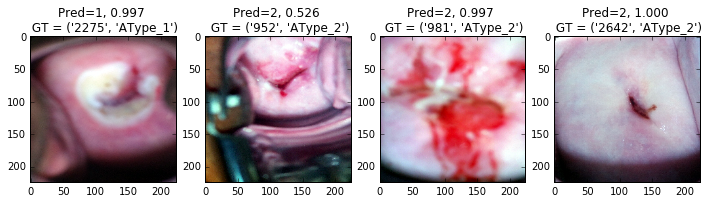

In [16]:
for x, y_true, info in flow:
    s = y_true.shape[0]
    y_pred = vgg.predict(x)
    print("--", total_counter*batch_size + s)    
    total_counter += 1
    plt_st(12, 4)
    for i in range(s):
        print(info[i], y_pred[i], y_true[i])
        plt.subplot(1, s, i+1)
        plt.title("Pred={}, {:.3f} \n GT = {}".format(np.argmax(y_pred[i])+1, np.max(y_pred[i]), info[i]))
        plt.imshow(scale_percentile(x[i, :, :, :].transpose([1, 2, 0])))
    break

In [19]:
(y_pred > 0.5).astype(np.float32)

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.]], dtype=float32)

### Logs

```
2017-05-03 22:40:53.569922 - Start training ...

-- Training parameters: 8, 50, 2752, 488

-- Fit stats of train dataset
Load existing file: /Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/input/generated/cnn_4_cervix_normal_opt=adam_seed=54321_stats.npz
No need to recompute statistics

-- Fit model
Epoch 1/50
2752/2752 [==============================] - 109s - loss: 1.0503 - acc: 0.4695 - recall: 0.1410 - precision: 0.4888 - val_loss: 1.0113 - val_acc: 0.5041 - val_recall: 0.1270 - val_precision: 0.6216
Epoch 2/50
2752/2752 [==============================] - 109s - loss: 1.0555 - acc: 0.4509 - recall: 0.1119 - precision: 0.4472 - val_loss: 0.9993 - val_acc: 0.4959 - val_recall: 0.2234 - val_precision: 0.6038
Epoch 3/50
2752/2752 [==============================] - 113s - loss: 1.0478 - acc: 0.4702 - recall: 0.1457 - precision: 0.5067 - val_loss: 0.9892 - val_acc: 0.4877 - val_recall: 0.2172 - val_precision: 0.6202
Epoch 4/50
2752/2752 [==============================] - 114s - loss: 1.0362 - acc: 0.4753 - recall: 0.1584 - precision: 0.5416 - val_loss: 0.9854 - val_acc: 0.4816 - val_recall: 0.1906 - val_precision: 0.6246
Epoch 5/50
2752/2752 [==============================] - 115s - loss: 1.0280 - acc: 0.4742 - recall: 0.1770 - precision: 0.5737 - val_loss: 0.9979 - val_acc: 0.4836 - val_recall: 0.2070 - val_precision: 0.5694
Epoch 6/50
2752/2752 [==============================] - 118s - loss: 1.0347 - acc: 0.4677 - recall: 0.1730 - precision: 0.5447 - val_loss: 1.0040 - val_acc: 0.4980 - val_recall: 0.1168 - val_precision: 0.5792
Epoch 7/50
2752/2752 [==============================] - 113s - loss: 1.0206 - acc: 0.4775 - recall: 0.1628 - precision: 0.5632 - val_loss: 0.9733 - val_acc: 0.5287 - val_recall: 0.2090 - val_precision: 0.6046
Epoch 8/50
2752/2752 [==============================] - 114s - loss: 1.0204 - acc: 0.4778 - recall: 0.1813 - precision: 0.5776 - val_loss: 0.9780 - val_acc: 0.4836 - val_recall: 0.2480 - val_precision: 0.5948
Epoch 9/50
2752/2752 [==============================] - 110s - loss: 1.0225 - acc: 0.4927 - recall: 0.1915 - precision: 0.5527 - val_loss: 0.9788 - val_acc: 0.4918 - val_recall: 0.2664 - val_precision: 0.5720
Epoch 10/50
2752/2752 [==============================] - 108s - loss: 1.0104 - acc: 0.5200 - recall: 0.2220 - precision: 0.5854 - val_loss: 0.9647 - val_acc: 0.5246 - val_recall: 0.2275 - val_precision: 0.5768
Epoch 11/50
2752/2752 [==============================] - 110s - loss: 1.0056 - acc: 0.4989 - recall: 0.2264 - precision: 0.6151 - val_loss: 0.9879 - val_acc: 0.5143 - val_recall: 0.1639 - val_precision: 0.5809
Epoch 12/50
2752/2752 [==============================] - 110s - loss: 1.0079 - acc: 0.4887 - recall: 0.1959 - precision: 0.5654 - val_loss: 0.9548 - val_acc: 0.5266 - val_recall: 0.2725 - val_precision: 0.5872
Epoch 13/50
2752/2752 [==============================] - 109s - loss: 1.0107 - acc: 0.4898 - recall: 0.2246 - precision: 0.5893 - val_loss: 0.9656 - val_acc: 0.5369 - val_recall: 0.2029 - val_precision: 0.6011
Epoch 14/50
2752/2752 [==============================] - 111s - loss: 1.0023 - acc: 0.5102 - recall: 0.2053 - precision: 0.5791 - val_loss: 0.9719 - val_acc: 0.5328 - val_recall: 0.2439 - val_precision: 0.5927
Epoch 15/50
2752/2752 [==============================] - 113s - loss: 1.0006 - acc: 0.4956 - recall: 0.2235 - precision: 0.5899 - val_loss: 0.9419 - val_acc: 0.5451 - val_recall: 0.2520 - val_precision: 0.6374
Epoch 16/50
2752/2752 [==============================] - 112s - loss: 0.9987 - acc: 0.5124 - recall: 0.2289 - precision: 0.5961 - val_loss: 0.9635 - val_acc: 0.5102 - val_recall: 0.2623 - val_precision: 0.6154
Epoch 17/50
2752/2752 [==============================] - 110s - loss: 0.9890 - acc: 0.5160 - recall: 0.2485 - precision: 0.6239 - val_loss: 0.9652 - val_acc: 0.5246 - val_recall: 0.2357 - val_precision: 0.6235
Epoch 18/50
2752/2752 [==============================] - 111s - loss: 0.9962 - acc: 0.5069 - recall: 0.2322 - precision: 0.5850 - val_loss: 0.9485 - val_acc: 0.5451 - val_recall: 0.2643 - val_precision: 0.6675
Epoch 19/50
2752/2752 [==============================] - 108s - loss: 0.9948 - acc: 0.5160 - recall: 0.2322 - precision: 0.5744 - val_loss: 0.9640 - val_acc: 0.5102 - val_recall: 0.2295 - val_precision: 0.6322
Epoch 20/50
2752/2752 [==============================] - 111s - loss: 0.9984 - acc: 0.5069 - recall: 0.2286 - precision: 0.5920 - val_loss: 0.9627 - val_acc: 0.5512 - val_recall: 0.2439 - val_precision: 0.6361
Epoch 21/50
2752/2752 [==============================] - 114s - loss: 0.9895 - acc: 0.5218 - recall: 0.2347 - precision: 0.5876 - val_loss: 0.9599 - val_acc: 0.4795 - val_recall: 0.2725 - val_precision: 0.6489
Epoch 22/50
2752/2752 [==============================] - 112s - loss: 0.9969 - acc: 0.5022 - recall: 0.2431 - precision: 0.5940 - val_loss: 0.9529 - val_acc: 0.5430 - val_recall: 0.2520 - val_precision: 0.6612
Epoch 23/50
2752/2752 [==============================] - 112s - loss: 0.9984 - acc: 0.5153 - recall: 0.2380 - precision: 0.5791 - val_loss: 0.9538 - val_acc: 0.5307 - val_recall: 0.2398 - val_precision: 0.5705
Epoch 24/50
2752/2752 [==============================] - 115s - loss: 0.9873 - acc: 0.5105 - recall: 0.2427 - precision: 0.6129 - val_loss: 0.9313 - val_acc: 0.5779 - val_recall: 0.2930 - val_precision: 0.6964
Epoch 25/50
2752/2752 [==============================] - 113s - loss: 0.9957 - acc: 0.5134 - recall: 0.2336 - precision: 0.5984 - val_loss: 0.9817 - val_acc: 0.4939 - val_recall: 0.2275 - val_precision: 0.5770
Epoch 26/50
2752/2752 [==============================] - 114s - loss: 0.9994 - acc: 0.5153 - recall: 0.2511 - precision: 0.5947 - val_loss: 0.9511 - val_acc: 0.5041 - val_recall: 0.2500 - val_precision: 0.6306
Epoch 27/50
2752/2752 [==============================] - 117s - loss: 0.9864 - acc: 0.5185 - recall: 0.2416 - precision: 0.5964 - val_loss: 0.9713 - val_acc: 0.5102 - val_recall: 0.2316 - val_precision: 0.5992
Epoch 28/50
2752/2752 [==============================] - 113s - loss: 0.9998 - acc: 0.5116 - recall: 0.2420 - precision: 0.5929 - val_loss: 0.9475 - val_acc: 0.5512 - val_recall: 0.2807 - val_precision: 0.6615
Epoch 29/50
2752/2752 [==============================] - 109s - loss: 0.9879 - acc: 0.5243 - recall: 0.2424 - precision: 0.6040 - val_loss: 0.9687 - val_acc: 0.5266 - val_recall: 0.2377 - val_precision: 0.5986
Epoch 30/50
2752/2752 [==============================] - 112s - loss: 0.9896 - acc: 0.5203 - recall: 0.2522 - precision: 0.6100 - val_loss: 0.9671 - val_acc: 0.5410 - val_recall: 0.2561 - val_precision: 0.6503
Epoch 31/50
2752/2752 [==============================] - 112s - loss: 0.9980 - acc: 0.5127 - recall: 0.2475 - precision: 0.6129 - val_loss: 0.9466 - val_acc: 0.5348 - val_recall: 0.2602 - val_precision: 0.6614
Epoch 32/50
2752/2752 [==============================] - 111s - loss: 0.9965 - acc: 0.5065 - recall: 0.2460 - precision: 0.5958 - val_loss: 0.9724 - val_acc: 0.5123 - val_recall: 0.2418 - val_precision: 0.6232
Epoch 33/50
2752/2752 [==============================] - 113s - loss: 0.9921 - acc: 0.5116 - recall: 0.2518 - precision: 0.5977 - val_loss: 0.9553 - val_acc: 0.5205 - val_recall: 0.2561 - val_precision: 0.6328
Epoch 34/50
2752/2752 [==============================] - 110s - loss: 0.9864 - acc: 0.5182 - recall: 0.2485 - precision: 0.5982 - val_loss: 0.9545 - val_acc: 0.5410 - val_recall: 0.2582 - val_precision: 0.6227
Epoch 35/50
 640/2752 [=====>........................] - ETA: 79s - loss: 1.0238 - acc: 0.5000 - recall: 0.2500 - precision: 0.5873
```

